In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
# Scikit-learn imports.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
# TensorFlow and Keras imports.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import to_categorical

In [6]:
#Read in the cleansed and collected data
df_sig_rets = pd.read_pickle('./stockdata.pkl')

In [22]:
# List of all unique stock-tickers in the dataset.
tickers = df_sig_rets.reset_index()['Ticker'].unique()
#Split the tickers using a simple 80/20 rule
tickers_train, tickers_test = train_test_split(tickers, train_size=0.8)
#Create train and test dataframe
df_train = df_sig_rets.loc[tickers_train]
df_test = df_sig_rets.loc[tickers_test]

In [117]:
# DataFrames with signals for training
X_train = df_train.drop(columns=['Total Log Return 1-3 Years'])
X_test = df_test.drop(columns=['Total Log Return 1-3 Years'])

# DataFrames with returns
y_train = df_train['Total Log Return 1-3 Years']
y_test = df_test['Total Log Return 1-3 Years']

In [118]:
# Scale and fit the signals
signal_scaler = StandardScaler()
signal_scaler.fit(X_train)
# Scale the training data
array = signal_scaler.transform(X_train)
df_scaled = pd.DataFrame(data=array,columns=X_train.columns,index=X_train.index)
X_train = df_scaled
# Scale the test data
array = signal_scaler.transform(X_test)
df_scaled = pd.DataFrame(data=array,columns=X_test.columns,index=X_test.index)
X_test = df_scaled

In [253]:
# Create a new Keras model.
model_regr = Sequential()
# input layer of Neural Network
num_signals = X_train.shape[1]
model_regr.add(InputLayer(input_shape=(num_signals,)))
# Layers of the network
#model_regr.add(Dense(512, activation='relu'))
#model_regr.add(Dense(256, activation='relu'))
#model_regr.add(Dense(128, activation='relu'))
#model_regr.add(Dense(64, activation='relu'))
#model_regr.add(Dense(32, activation='relu'))
#model_regr.add(Dense(16, activation='relu'))
#model_regr.add(Dense(8, activation='relu'))
model_regr.add(Dense(24, activation='relu'))
#model_regr.add(Dense(16, activation='relu'))
#model_regr.add(Dense(8, activation='relu'))
# Output of the Neural Network.
model_regr.add(Dense(1))
# Compile the model
model_regr.compile(loss='mse', metrics=['mae'],optimizer=Adam(lr=0.001))
model_regr.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 24)                864       
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 25        
Total params: 889
Trainable params: 889
Non-trainable params: 0
_________________________________________________________________


In [254]:
#Arguments for Keras fit()
fit_args = {
        'batch_size': 8192,
        #num of iterations
        'epochs': 50,
        #80/20 rule for validation
        'validation_split': 0.2,
        # Show status
        'verbose': 0,
    }

In [255]:
%%time
history_regr = model_regr.fit(x=X_train.values,y=y_train.values, **fit_args)

CPU times: user 27.5 s, sys: 2.33 s, total: 29.9 s
Wall time: 15.5 s


In [256]:
%%time
y_train_pred = model_regr.predict(X_train.values)
y_test_pred = model_regr.predict(X_test.values)

CPU times: user 16.6 s, sys: 4.83 s, total: 21.4 s
Wall time: 14.8 s


In [257]:
print('R^2 Value for trained data: ',r2_score(y_true=y_train, y_pred=y_train_pred))
print('R^2 Value for Test data: ',r2_score(y_true=y_test, y_pred=y_test_pred))

R^2 Value for trained data:  0.1682123716001448
R^2 Value for Test data:  -0.1785575061280209


In [292]:
# Column-name 
TOTAL_RETURN_PRED = 'Total log Return Predicted'
# Formating the data to be plotted
df_y_train = pd.DataFrame(y_train)
df_y_train[TOTAL_RETURN_PRED] = y_train_pred
df_y_test = pd.DataFrame(y_test)
df_y_test[TOTAL_RETURN_PRED] = y_test_pred

In [404]:
#Creates a dataframe tickers and their r2 value
df_test_r2 = pd.DataFrame(columns = ['Ticker','r^2'])
for t in tickers_test:
    temp_df = df_y_test.loc[t]
    #add the ticker and r^2 value to the df
    r2 = r2_score(temp_df['Total Log Return 1-3 Years'],temp_df['Total log Return Predicted'])
    new_row = {'Ticker':t,'r^2':r2}
    df_test_r2 = df_test_r2.append(new_row,ignore_index=True)
df_test_r2 = df_test_r2.sort_values(by=['r^2'],ascending=False).reset_index(drop=True)
#Same as above but for trained data
df_train_r2 = pd.DataFrame(columns = ['Ticker','r^2'])
for t in tickers_train:
    temp_df = df_y_train.loc[t]
    #add the ticker and r^2 value to the df
    r2 = r2_score(temp_df['Total Log Return 1-3 Years'],temp_df['Total log Return Predicted'])
    new_row = {'Ticker':t,'r^2':r2}
    df_train_r2 = df_train_r2.append(new_row,ignore_index=True)
df_train_r2 = df_train_r2.sort_values(by=['r^2'],ascending=False).reset_index(drop=True)

In [396]:
def plotTestStock(userTicker):
    try:
        index = int(np.where(tickers_test == userTicker)[0])
    except:
        print('Stock ticker ',userTicker,' not found :(')
        return
    #index = int(np.where(tickers_test == userTicker)[0])
    ticker = tickers_test[index]
    title = "Predicted log stock return from test set: " + ticker 
    #negitive used to hide output
    _= df_y_test.loc[ticker].plot(title=title,  ylabel='Total log return')

In [397]:
def plotTrainStock(userTicker):
    try:
        index = int(np.where(tickers_train == userTicker)[0])
    except:
        print('Stock ticker ',userTicker,' not found :(')
        return
    #title = "Predicted stock return from trained set " + ticker 
    ticker = tickers_train[index]
    title = "Predicted log stock return from trained set: " + ticker 
    _= df_y_train.loc[ticker].plot(title=title,  ylabel='Total log return')

In [220]:
#List of training tickers
print('List of training tickers: ',tickers_train)

List of training tickers:  ['HELE' 'SLCA' 'HEAR' 'JNJ' 'CNK' 'DNB' 'SCSC' 'ABM' 'EXPE' 'ENVA' 'OXY'
 'DEST' 'RTN' 'DIN' 'TECH' 'MKC' 'NFLX' 'EMN' 'GILD' 'GHDX' 'CIK' 'JJSF'
 'PCMI' 'BRSS' 'EIGI' 'FONR' 'JOUT' 'TUP' 'CIDM' 'NKTR' 'NBL' 'EXA' 'FELE'
 'PLPC' 'PNW' 'PTEN' 'GWRE' 'AKAM' 'WAT' 'CQP' 'BURL' 'MD' 'SNI' 'FLWS'
 'MSA' 'KND' 'HABT' 'QEP' 'ES' 'RMD' 'CMI' 'DXLG' 'HALO' 'WEC' 'NKE'
 'RAVE' 'ATHN' 'WNC' 'GXP' 'SPB' 'COL' 'AAON' 'MTSI' 'BDX' 'BKNG' 'WMT'
 'EGY' 'STMP' 'ADP' 'ORCL' 'CYCC' 'AVY' 'HRL' 'HSIC' 'PII' 'MON' 'MCHP'
 'PSX' 'CENT' 'CSS' 'FRAN' 'CELG' 'HNNA' 'RS' 'TYPE' 'NEM' 'AREX' 'TBTC'
 'FLR' 'JSDA' 'CSU' 'ANSS' 'UDR' 'SHOS' 'NSSC' 'FGEN' 'ARE' 'COP' 'CHE'
 'SYMC' 'SMTC' 'CHDN' 'NPTN' 'TFX' 'ALSN' 'SHW' 'LNG' 'FORM' 'ALG' 'TSCO'
 'SMLP' 'RAD' 'PAHC' 'TXMD' 'CF' 'RGEN' 'INVA' 'WR' 'INTU' 'LDOS_old'
 'ISIL' 'FMC' 'CRS' 'CSGP' 'WOR' 'PSA' 'FIVE' 'MNK' 'CRC' 'CAG' 'MLM'
 'SCVL' 'EVC' 'MYGN' 'MELI' 'WTW' 'RCII' 'FARM' 'AVGR' 'LH' 'WFT_old'
 'FDC' 'AMSWA' 'W' 'MEET' 'LBTYA' 'BCR

In [221]:
#List of testing tickers
print('List of testing tickers: ',tickers_test)

List of testing tickers:  ['ENDP_old' 'RP' 'IQV' 'HOG' 'OXM' 'GHC' 'COG' 'EQR' 'AHPI' 'BBRG' 'LEG'
 'CAMP' 'ROL' 'ADM' 'ASPN' 'DRE' 'JBHT' 'WDC' 'TGI' 'MRVL' 'AAN' 'PPIH'
 'HRC' 'ACAD' 'MGPI' 'PPSI' 'PCG' 'LSTR' 'SPAN' 'PEB' 'AWX' 'TA' 'NLS'
 'ISSC' 'PRTS' 'FKWL' 'AZZ' 'NP' 'AIMC' 'BGS' 'PSDV' 'CONN' 'SOFO' 'BAH'
 'DHX' 'SWX' 'SKX' 'HDS' 'AGN_old' 'NUE' 'OMI' 'PIR' 'VRA' 'NEO' 'KRA'
 'GPRE' 'DG' 'NEE' 'CE' 'ATVI' 'ZUMZ' 'RT' 'ITRI' 'MPC' 'ASPU' 'LNT' 'SBH'
 'SMRT' 'CORT' 'CDR' 'WRI' 'HZO' 'TIS' 'XPO' 'PZZA' 'AMTD' 'FIX' 'DISCA'
 'WEN' 'WU' 'OLN' 'IPXL' 'MAN' 'STAY' 'CMPR' 'SBAC' 'FAST' 'CCXI' 'FNSR'
 'USCR' 'MTBC' 'AMG' 'WFM' 'BMRN' 'HURN' 'CVGI' 'LLL' 'DE' 'IPAR' 'NUVA'
 'CBB' 'JWA' 'COTY' 'VZ' 'HCA' 'BGSF' 'REXR' 'CPN' 'IVAC' 'ZAGG' 'CMC'
 'NVEC' 'VIA' 'AAWW' 'HAYN' 'PRCP' 'CHGG' 'NAV' 'CALD' 'CBG' 'IRM' 'FLT'
 'FB' 'RECN' 'GCO' 'BREW' 'MAMS' 'INCY' 'WYNN' 'LTRX' 'STX' 'HUBB' 'NCMI'
 'MN' 'NVR' 'CSGS' 'DLB' 'GUID' 'UNFI' 'CNSL' 'WWD' 'HNI' 'LSI' 'PPHM'
 'WSM' 'EEI' 'VEC' 'TWTR' 'ANET

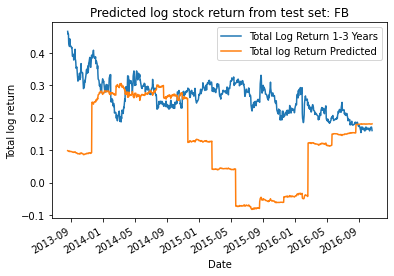

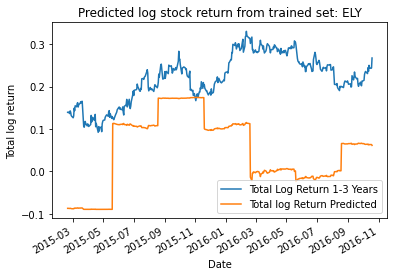

In [418]:
plotTestStock('FB')
plotTrainStock('ELY')

In [365]:
#Get the test stock with the highest r2 value
best = df_test_r2[df_test_r2['r^2']==df_test_r2['r^2'].max()]


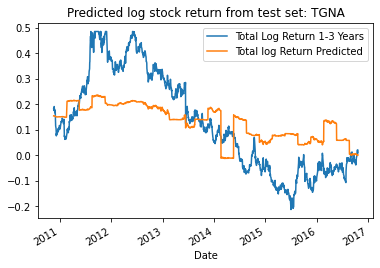

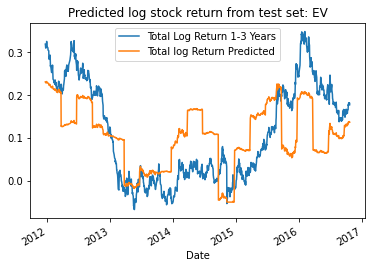

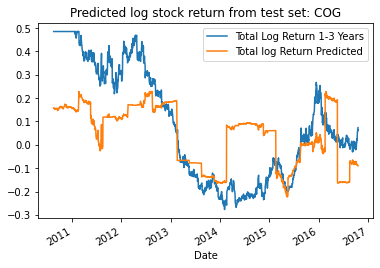

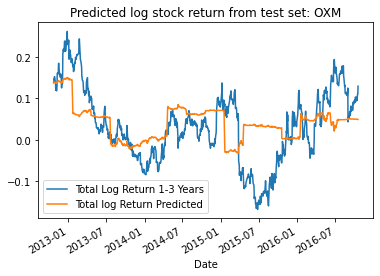

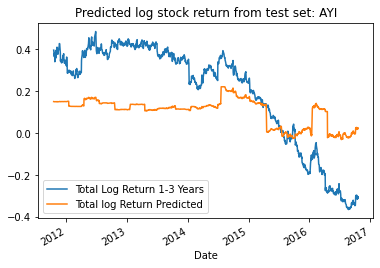

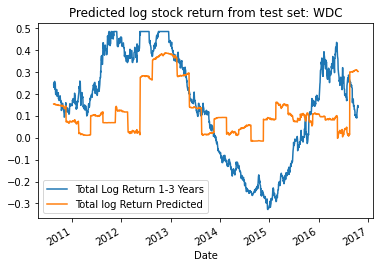

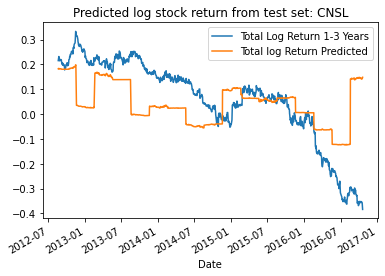

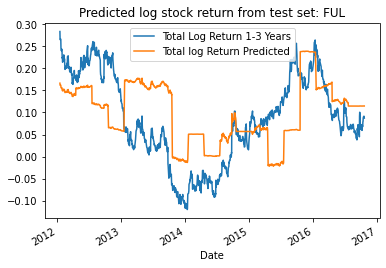

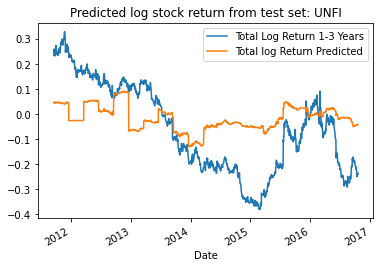

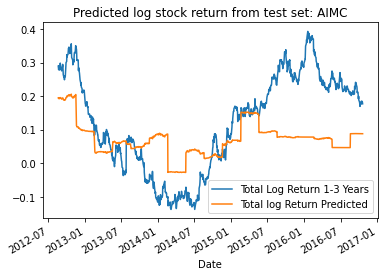

In [382]:
#Top 10 best predicted
for i in range(0,10):
    plotTestStock(df_test_r2['Ticker'].iloc[i])

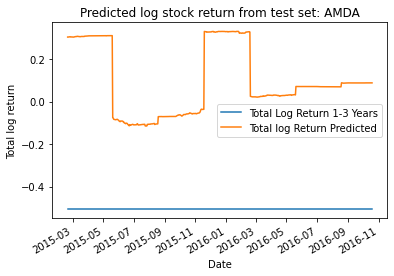

In [402]:
#Worst predicted
plotTestStock(df_test_r2['Ticker'].iloc[-1])

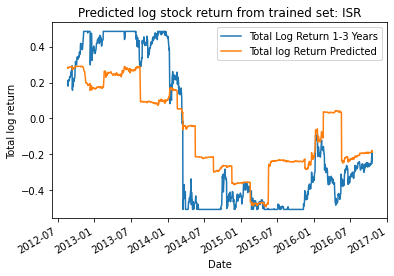

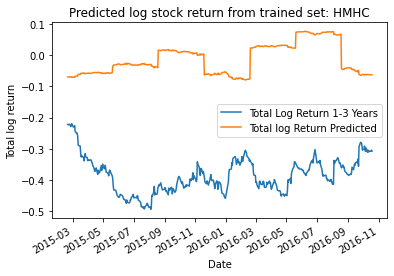

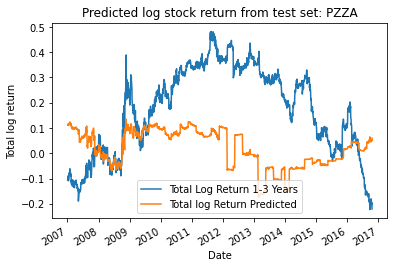

In [434]:
#Best train predicted
plotTrainStock(df_train_r2['Ticker'].iloc[0])
#Worst train predicted
plotTrainStock(df_train_r2['Ticker'].iloc[-20])
#median test stock
median = int(df_test_r2.shape[0]/2)
plotTestStock(df_test_r2['Ticker'].iloc[median])

In [432]:
int(df_train_r2.shape[0])

941